# Simple back testing program for given price dataset
**Author: Shaolun Du, Date: 03/17/18**
* Please provide data set in the form of .csv named with 'data.csv'
* Please run with Jupyter Notebook with Python 3
* Comments and suggestions to 'Shaolun.du@gmail.com'

In [26]:
# Necessary libiaries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta

In [27]:
# Data Loader
def Data_loader(filename):
    # Load data into dataframe and get rebalance dates list
    dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d')
    df = pd.read_csv(filename, delimiter=',', index_col=0, parse_dates=True, date_parser=dateparse, names=['Date','IF00.CFE','IC00.CFE','TF00.CFE','AU00.SHF','159920.OF','511880.SH'], header = 0)
    grouped = df.groupby(pd.Grouper(freq='m'))
    pct_chang_df = df.pct_change().fillna(0)
    Rebalance_date_list = [m for m,data in grouped] 
    Rebalance_date_list = pd.to_datetime(Rebalance_date_list, format = '%Y/%m/%d')
    
    return df,pct_chang_df,Rebalance_date_list

In [28]:
# Objective function for mean-variance optimization
def M_V(x, omega):
    return np.matrix(x) * omega * np.matrix(x).T

In [29]:
# Objective function for Risk-Parity optimization
def R_P(x, omega):
    tmp = (omega * np.matrix(x).T).A1
    risk = x * tmp
    delta_risk = [sum((i - risk)**2) for i in risk]
    return sum(delta_risk)

In [30]:
# Weights Computer
def get_weights(method, pct_chang_df, Rebalance_date_list):
    # Compute weights according to different methods 
    # User inputs = {'Equal', 'MV', 'RP', 'MT'}
    num_assets = len(df.columns)
    weights = []
    # Ensure we have at least one year records for weight computing
    early_start_date = pct_chang_df.index[0] + relativedelta(years=1)
    for date in Rebalance_date_list:
        # Condition for earliest start date
        if date >= early_start_date:
            # Slicing for date range with 1 year
            mask = (pct_chang_df.index >= date-relativedelta(years=1)) & (pct_chang_df.index <= date)
            cov_mat = pct_chang_df.loc[mask].cov()
            omega = np.matrix(cov_mat.values)  # 协方差矩阵 
            x0 = np.ones(omega.shape[0]) / omega.shape[0]  
            bnds = tuple((0, None) for x in x0)
            cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})
            options={'disp': False, 'maxiter': 1000, 'ftol': 1e-20}

            if method == 'Equal':
                # Equally weights portfolio
                weights.append((np.ones(num_assets)/num_assets, date))
            elif method == 'MV':
                # M-V weights portfolio
                temp = minimize(M_V, x0, args=(omega), bounds=bnds, constraints=cons, method='SLSQP', options=options)
                weights.append((temp['x'],date)) 
            elif method == 'RP':
                # Risk-Parity weights portfolio
                temp = minimize(R_P, x0, args=(omega), bounds=bnds, constraints=cons, method='SLSQP', options=options)
                weights.append((temp['x'],date))
            elif method == 'MT':
                # Using momentum strategy weights portfolio
                weights = []
            else:
                # Error inputs
                print('Cannot find the method---Error inputs')
    
    return weights

In [31]:
# Compute Net Portfolio Wealth 
# NOTE: We have to apply the result weights into next monthly period.
def comput_net_wealth(pct_chang_df, weights):
    net_wealth = []
    # Compute portfolio net wealth with rebalance dates
    i = -1
    rebalance_date = weights[0][1]
    for idx, row in pct_chang_df.iterrows():
        if idx >= rebalance_date:
            i += 1
        # When i >=0 means we can start rebalance
        if i >= 0:
            rebalance_date = weights[i][1]
            cur_weights = weights[i][0]
            # Store net returns into dictionary with date and returns
            net_wealth.append({'Date':idx, 'Return':row.dot(cur_weights)})
    
    return pd.DataFrame(net_wealth).set_index('Date')

In [32]:
# Calculate important portfolio statistics
def compute_stats(net_welath, rf_rate):
    # Compute Sharpe Ratio, Max_Drawdown, Annually return and Annually vol
    sharpe_ratio = (net_welath.mean()*252-rf_rate)/(net_welath.std()*np.sqrt(252))
    annually_return = net_welath.mean()*252
    annually_vol = net_welath.std()*np.sqrt(252)
    
    # Get all possible maxdrawdown at every date time
    cum_returns = net_welath.add(1).cumprod()
    drawdown =  1 - cum_returns.div(cum_returns.cummax())

    return (float(sharpe_ratio), float(annually_return), float(annually_vol), float(drawdown.max()))
    

Portfolio statistics: Sharpe Ratio = 0.7174, Annually Return = 0.0377, Annually Vol = 0.0246, Max Drawdown = 0.0238


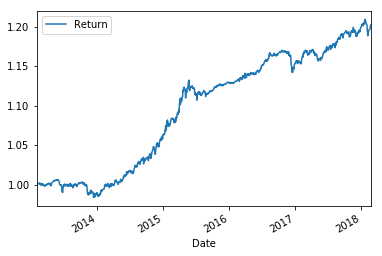

In [33]:
###########################
# Main program starts here:

# Risk-free rate
rf_rate = 0.02
# Specify file name
filename = 'data.csv'
# Load data
df,pct_chang_df,Rebalance_date_list = Data_loader(filename)
# Specify method = ['Equal'(Equally weighted), 'MV'(Mean Variance), 'RP'(Risk Parity), 'MT'(Momentum strategy)]
method = 'RP'
weights = get_weights(method, pct_chang_df, Rebalance_date_list)
net_welath = comput_net_wealth(pct_chang_df, weights)
net_change = net_welath.add(1).cumprod()
net_change.plot()
# The order in stats = [sharpe_ratio, annually_return, annually_vol, max_drawdown]
stats = compute_stats(net_welath, rf_rate)

print("Portfolio statistics: Sharpe Ratio = %2.4f, Annually Return = %2.4f, Annually Vol = %2.4f, Max Drawdown = %2.4f" % stats)